In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("/home/koukouzasg/CODE/Mask_RCNN")  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.config import Config

# Import WAD config
sys.path.append(os.path.join(ROOT_DIR, "samples/wadrivng/"))  # To find local version
import wad

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
WAD_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_wad_0040.h5")

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

Using TensorFlow backend.


In [2]:
config = wad.WadInferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                20
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE    

In [3]:
model = modellib.MaskRCNN(mode="inference", config=config,
                                  model_dir=MODEL_DIR)

model.load_weights(WAD_MODEL_PATH, by_name=True)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [4]:
# Load WAD dataset
dataset = wad.WadDataset()
dataset.load_wad(IMAGE_DIR, "test")
dataset.prepare()

# Print class names
print(dataset.class_names)

Base dir : /home/koukouzasg/CODE/Mask_RCNN/images/test
Data loaded from : /home/koukouzasg/CODE/Mask_RCNN/images/test
9 files
['BG', 'car', 'motorcycle', 'bicycle', 'pedestrian', 'truck', 'bus', 'tricycle']


Processing 1 images
image                    shape: (426, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


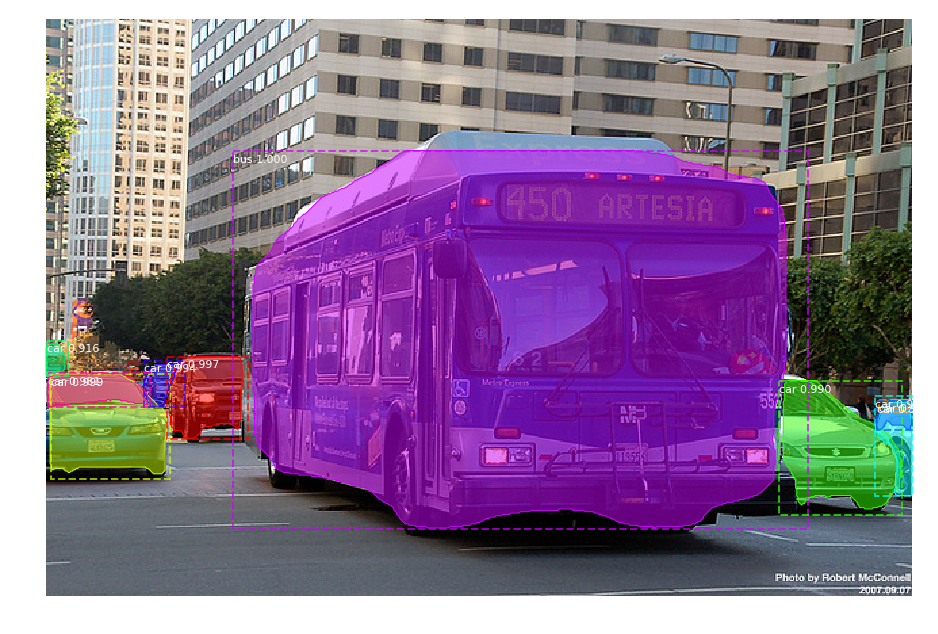

In [10]:
# Load a random image from the images folder
image_dir = os.path.join(IMAGE_DIR, "test")
file_names = next(os.walk(image_dir))[2]
image = skimage.io.imread(os.path.join(image_dir, random.choice(file_names)))
#image = skimage.io.imread(os.path.join(IMAGE_DIR, "img1.png"))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'])

In [11]:
def rle_encode(mask):
    """Encodes a mask in Run Length Encoding (RLE).
    Returns a string of space-separated values.
    """
    assert mask.ndim == 2, "Mask must be of shape [Height, Width]"
    # Flatten it column wise
    m = mask.T.flatten()
    # Compute gradient. Equals 1 or -1 at transition points
    g = np.diff(np.concatenate([[0], m, [0]]), n=1)
    # 1-based indicies of transition points (where gradient != 0)
    rle = np.where(g != 0)[0].reshape([-1, 2]) + 1
    # Convert second index in each pair to lenth
    rle[:, 1] = rle[:, 1] - rle[:, 0]
    rle_string = ""
    for n in range(len(rle)):
        rle_string += "{} {}|".format(rle[n, 0],rle[n, 1])
    return rle_string

In [12]:
def mask_to_rle(image_id, mask, scores):
    "Encodes instance masks to submission format."
    assert mask.ndim == 3, "Mask must be [H, W, count]"
    # If mask is empty, return line with image ID only
    if mask.shape[-1] == 0:
        return "{},".format(image_id)
    # Remove mask overlaps
    # Multiply each instance mask by its score order
    # then take the maximum across the last dimension
    order = np.argsort(scores)[::-1] + 1  # 1-based descending
    mask = np.max(mask * np.reshape(order, [1, 1, -1]), -1)
    # Loop over instance masks
    lines = []
    for o in order:
        m = np.where(mask == o, 1, 0)
        # Skip if empty
        if m.sum() == 0.0:
            continue
        rle = rle_encode(m)
        lines.append("{}, {}, {}".format(image_id, m.sum(), rle))
    return "\n".join(lines)

In [13]:
submission = []
# Encode image to RLE. Returns a string of multiple lines
#source_id = dataset.image_info[image_id]["id"]
rle = mask_to_rle("img1", r["masks"], r["scores"])
submission.append(rle)

# Save to csv file
submission = "ImageId,PixelCount,EncodedPixels\n" + "\n".join(submission)
file_path = os.path.join(ROOT_DIR, "submit.csv")
with open(file_path, "w") as f:
    f.write(submission)
print("Saved to ", ROOT_DIR)

Saved to  /home/koukouzasg/CODE/Mask_RCNN
